# Validation of Pipeline Signals & Analysis of Results

This notebook is a step-by-step inspection of the pipeline, validation of the signals + outcomes data, and an analysis of the results.

Process covered in this notebook:

1. Pipeline Integrity & Coverage Checks:  Did the pipeline produce what we think it produced, for the full universe we expect?
2. Outcome Variable Sanity & Dynamics:  Are the outcome series (levels and deltas) well-behaved, interpretable, and economically plausible?
3. Tax Signal Construction Validation: Do the tax signals (raw, per-capita, % GDP, concentration metrics) look correct and internally consistent?
4. Lag & Rolling Transform Verification: Are the rolling windows and lags aligned in time the way we intended (no look-ahead, no leakage)?
5. Exposure–Outcome Correlation Scan (Pre-Model): Before regression: do simple correlations and plots show any directional signal at all?
6. Fixed Effects Regression Diagnostics: Do coefficients have stable signs, reasonable magnitudes, and sensible standard errors?
7. Cross-Outcome Consistency Checks: Do results make sense across different outcomes (GDP per capita, dependency ratios, etc.)?
8. Heterogeneity & Edge-Case States:  Are results being driven by a small set of states, sectors, or time periods?  (incomplete)
9. Narrative Readiness Test:  Can we explain the results clearly to a non-technical judge without hand-waving?  (TBD)


In [87]:
import pandas as pd
import numpy

from pathlib import Path

import matplotlib.pyplot as plt

In [88]:
# Set folder paths

project_root = Path.cwd().parent
print(f"project_root: {project_root}")

data_folder = project_root / "data"
print(f"data_folder: {data_folder}")

outputs_folder = project_root / "outputs"
print(f"outputs_folder: {outputs_folder}")

project_root: /Users/jeffallen/Development/portfolio-projects/UmichDatathon2026
data_folder: /Users/jeffallen/Development/portfolio-projects/UmichDatathon2026/data
outputs_folder: /Users/jeffallen/Development/portfolio-projects/UmichDatathon2026/outputs


# 1. Pipeline Integrity & Coverage Checks

1. Confirm the the expected output files exist. ✅
2. Check coverage on the primary key (state, period). See below.
3. Check whether tax and outcomes align to the panel ("join completeness"). See below

In [89]:
### Coverage checks on the primary key: (state, period)

panel = pd.read_csv(data_folder / "processed/panel_state_quarter.csv")
tax = pd.read_csv(data_folder / "processed/tax_signals.csv")
out = pd.read_csv(data_folder / "processed/outcomes.csv")

def pk_report(df, name):
    print(f"\n=== {name} ===")
    print("rows:", len(df))
    print("cols:", df.shape[1])
    # adjust if your columns are named differently
    pk = df[["state","period"]].copy()
    print("unique (state,period):", len(pk.drop_duplicates()))
    print("duplicate pk rows:", len(pk) - len(pk.drop_duplicates()))
    print("states:", pk["state"].nunique())
    print("periods:", pk["period"].nunique())
    print("period min/max:", pk["period"].min(), "→", pk["period"].max())

pk_report(panel, "panel_state_quarter")
pk_report(tax, "tax_signals")
pk_report(out, "outcomes")


=== panel_state_quarter ===
rows: 4264
cols: 11
unique (state,period): 4264
duplicate pk rows: 0
states: 52
periods: 82
period min/max: 2005Q1 → 2025Q2

=== tax_signals ===
rows: 4264
cols: 45
unique (state,period): 4264
duplicate pk rows: 0
states: 52
periods: 82
period min/max: 2005Q1 → 2025Q2

=== outcomes ===
rows: 4264
cols: 34
unique (state,period): 4264
duplicate pk rows: 0
states: 52
periods: 82
period min/max: 2005Q1 → 2025Q2


In [90]:
### Check whether tax and outcomes align to the panel

def coverage_against_panel(panel, df, name):
    p = panel[["state","period"]].drop_duplicates()
    d = df[["state","period"]].drop_duplicates()
    merged = p.merge(d, on=["state","period"], how="left", indicator=True)
    missing = (merged["_merge"] == "left_only").mean()
    print(f"{name}: % panel keys missing from {name} =", round(100*missing, 2), "%")

coverage_against_panel(panel, tax, "tax_signals")
coverage_against_panel(panel, out, "outcomes")

tax_signals: % panel keys missing from tax_signals = 0.0 %
outcomes: % panel keys missing from outcomes = 0.0 %


# 2. Outcome Variable Sanity & Dynamics

1. Inventory & classificaiton of outcomes. See below.
2. Descriptive statistics. See below.
3. Time-series sanity (macro check reality). See below.
4. Cross-state dispersion (is there signal?) ... See below.
5. Within- vs Between-State Signal (FE viability test) ... See below.

In [103]:
### Classify outcomes into buckets
### This code block gets the list and then we manually classified.

out = pd.read_csv(data_folder / "processed/outcomes.csv")
out.columns.tolist()

['state',
 'period',
 'gdp_per_capita',
 'delta_gdp_per_capita_lag8',
 'dependency_ratio',
 'senior_share',
 'working_share',
 'delta_dependency_ratio_lag8',
 'delta_senior_share_lag8',
 'delta_working_share_lag8',
 'econ_hhi',
 'econ_entropy_norm',
 'delta_econ_hhi_lag8',
 'delta_econ_entropy_norm_lag8',
 'gdp_private_share',
 'gdp_gov_share',
 'gdp_knowledge_share',
 'delta_gdp_knowledge_share_lag8',
 'business_formation_rate_per_1k',
 'applications_to_formations_ratio',
 'delta_business_formation_rate_per_1k_lag8',
 'delta_applications_to_formations_ratio_lag8',
 'tax_hhi',
 'tax_entropy_norm',
 'delta_tax_hhi_lag8',
 'delta_tax_entropy_norm_lag8',
 'sales_tax_dependency',
 'income_tax_dependency',
 'property_tax_dependency',
 'resource_severance_dependency',
 'delta_sales_tax_dependency_lag8',
 'delta_income_tax_dependency_lag8',
 'delta_property_tax_dependency_lag8',
 'delta_resource_severance_dependency_lag8']

## Classifications

### Levels:
- gdp_per_capita
- dependency_ratio
- econ_hhi
- tax_hhi
- sales_tax_dependency
- income_tax_dependency
- property_tax_dependency
- resource_severance_dependency

### Rates / Shares:
- senior_share
- working_share (minor naming note below)
- econ_entropy_norm
- gdp_private_share
- gdp_gov_share
- gdp_knowledge_share
- business_formation_rate_per_1k
- applications_to_formations_ratio
- tax_entropy_norm

### First differences / deltas:
- delta_gdp_per_capita_lag8
- delta_dependency_ratio_lag8
- delta_senior_share_lag8
- delta_working_share_lag8
- delta_econ_hhi_lag8
- delta_econ_entropy_norm_lag8
- delta_gdp_knowledge_share_lag8
- delta_business_formation_rate_per_1k_lag8
- delta_applications_to_formations_ratio_lag8
- delta_tax_hhi_lag8
- delta_tax_entropy_norm_lag8
- delta_sales_tax_dependency_lag8
- delta_income_tax_dependency_lag8
- delta_property_tax_dependency_lag8
- delta_resource_severance_dependency_lag8

### For Modeling:
- delta_gdp_per_capita_lag8
- delta_dependency_ratio_lag8

**one structural adaptation metric:**
- delta_econ_entropy_norm_lag8 or
- delta_gdp_knowledge_share_lag8


### Summary of Outcome Design

We have:
- State capacity
- Demographic pressure
- Economic structure
- Adaptation dynamics

“Tax systems don’t just fund states —
 they train states toward certain economic compositions,
 which then shape long-run prosperity and fiscal resilience.”

In [104]:
### Inspect descriptive statistics of primary outcome metrics

out = pd.read_csv(data_folder / "processed/outcomes.csv")

core_outcomes = [
    "gdp_per_capita",
    "delta_gdp_per_capita_lag8",
    "dependency_ratio",
    "delta_dependency_ratio_lag8",
    "econ_entropy_norm",
    "delta_econ_entropy_norm_lag8",
    "gdp_knowledge_share",
    "delta_gdp_knowledge_share_lag8",
]

out[core_outcomes].describe(
    percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
).T


,count,mean,std,min,1%,5%,50%,95%,99%,max
gdp_per_capita,4264.0,0.059633,0.025190,0.027935,0.032676,0.036842,0.054048,0.091767,0.184654,0.269627
delta_gdp_per_capita_lag8,3848.0,0.004247,0.004475,-0.014674,-0.005320,-0.001392,0.003395,0.012775,0.018303,0.034890
dependency_ratio,1020.0,0.655366,0.044521,0.456622,0.459865,0.587451,0.664340,0.708400,0.732555,0.744122
delta_dependency_ratio_lag8,612.0,0.010688,0.007146,-0.019118,-0.016762,0.000127,0.011602,0.021292,0.024195,0.026181
econ_entropy_norm,4264.0,0.881030,0.034059,0.700064,0.717549,0.812505,0.887886,0.912849,0.918619,0.925084
delta_econ_entropy_norm_lag8,3848.0,0.001178,0.008853,-0.051273,-0.022130,-0.010449,0.000777,0.014880,0.031816,0.064066
gdp_knowledge_share,4264.0,0.171919,0.062666,0.051955,0.070139,0.094069,0.164130,0.305144,0.373662,0.427127
delta_gdp_knowledge_share_lag8,3848.0,0.001185,0.010930,-0.084572,-0.032201,-0.015314,0.001153,0.017117,0.031116,0.071359


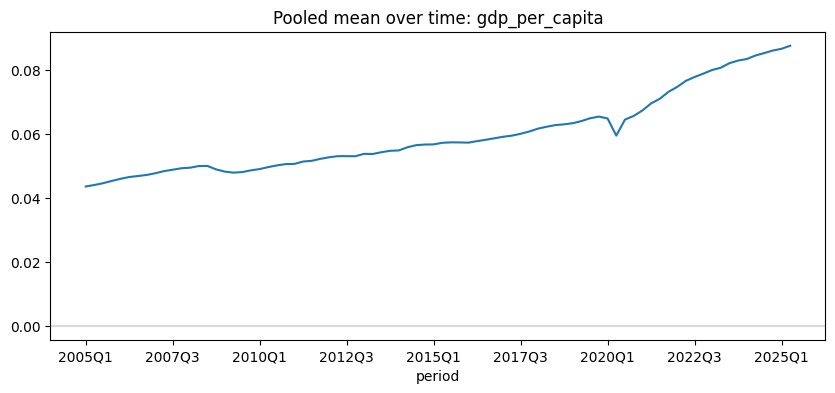

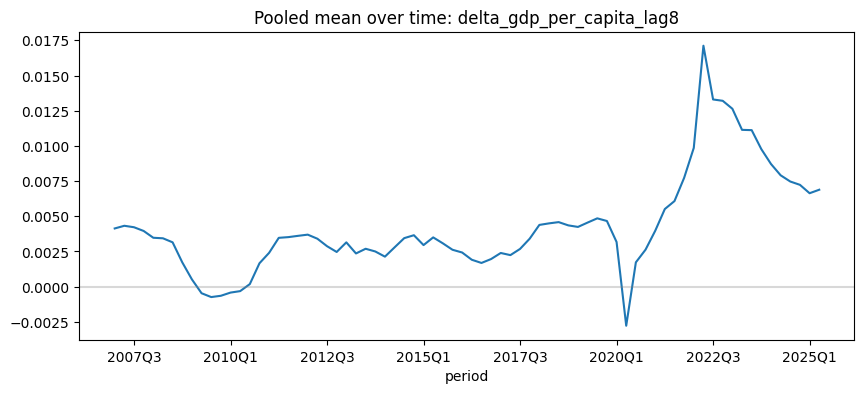

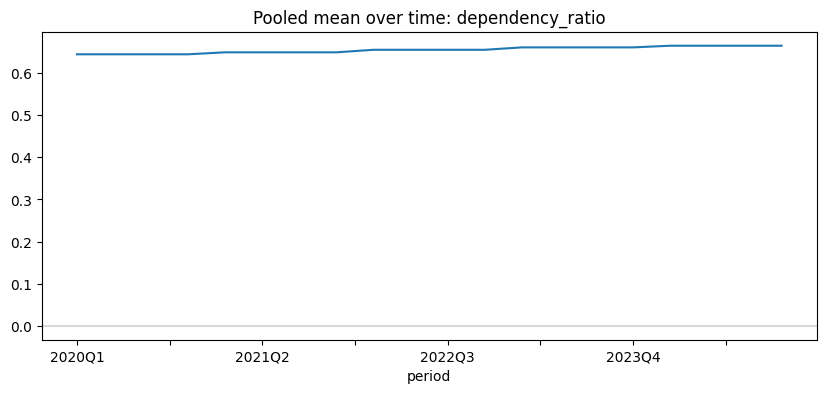

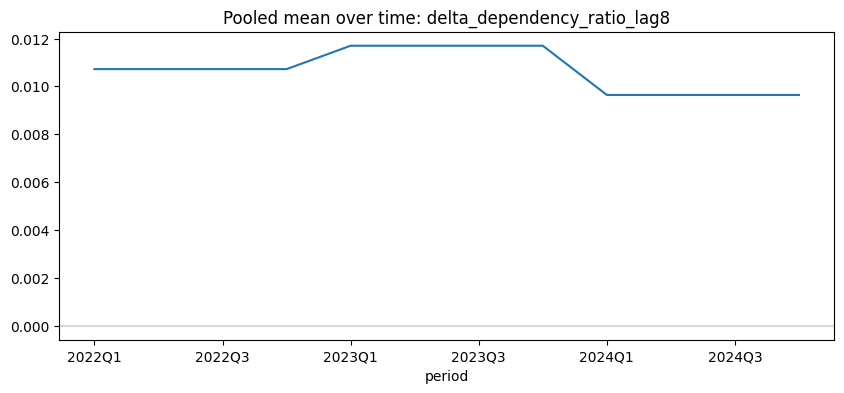

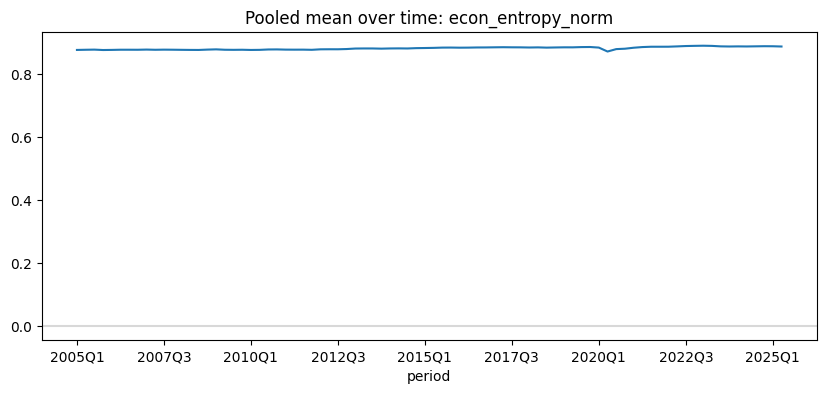

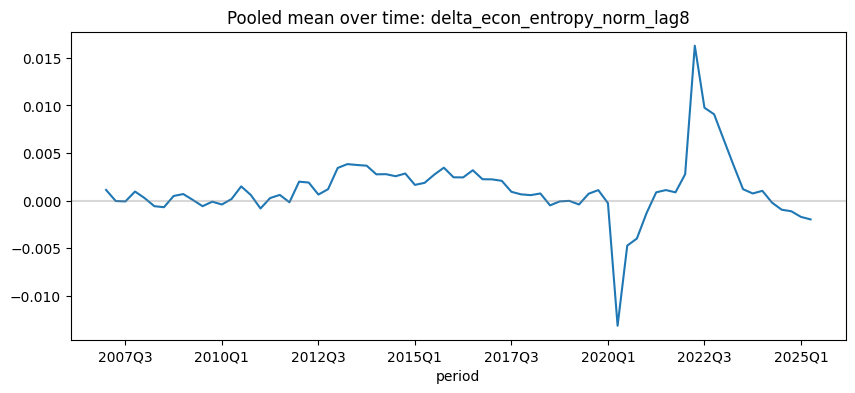

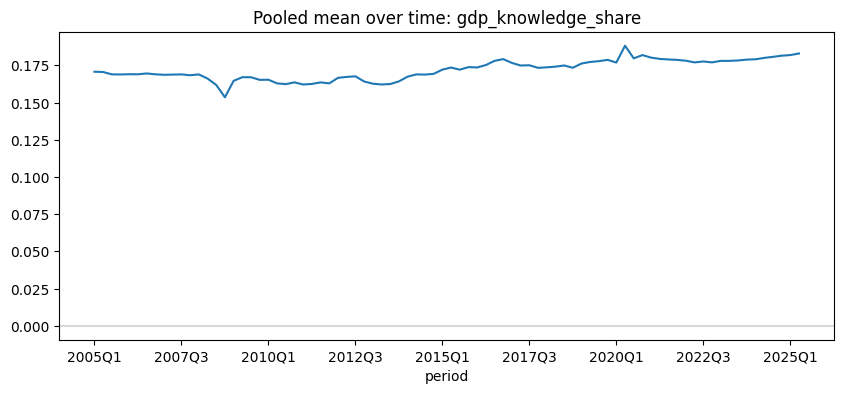

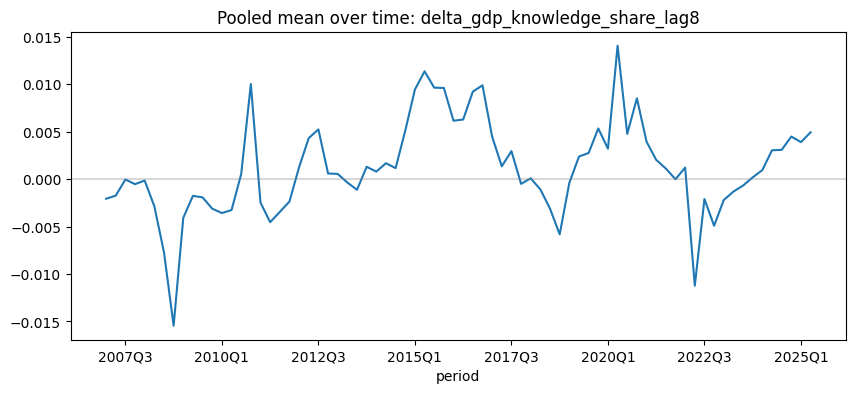

In [105]:
# time series sanity check
# note: shocks for 2008 and 2020 (financial crisis and covid)

for col in core_outcomes:
    out.groupby("period")[col].mean().plot(
        title=f"Pooled mean over time: {col}",
        figsize=(10,4)
    )
    plt.axhline(0, color="gray", alpha=0.3)
    plt.show()


In [106]:
### Cross state dispersion (is there signal?)

for col in core_outcomes:
    by_state_std = out.groupby("state")[col].std()
    print(col)
    print(by_state_std.describe())
    print()


gdp_per_capita
count    52.000000
mean      0.012306
std       0.004124
min       0.007456
25%       0.009781
50%       0.011626
75%       0.013017
max       0.033635
Name: gdp_per_capita, dtype: float64

delta_gdp_per_capita_lag8
count    52.000000
mean      0.004015
std       0.001467
min       0.002460
25%       0.003100
50%       0.003601
75%       0.004223
max       0.009023
Name: delta_gdp_per_capita_lag8, dtype: float64

dependency_ratio
count    51.000000
mean      0.008222
std       0.004030
min       0.000638
25%       0.005217
50%       0.009089
75%       0.010622
max       0.016725
Name: dependency_ratio, dtype: float64

delta_dependency_ratio_lag8
count    51.000000
mean      0.001691
std       0.000829
min       0.000108
25%       0.001180
50%       0.001593
75%       0.002249
max       0.003686
Name: delta_dependency_ratio_lag8, dtype: float64

econ_entropy_norm
count    52.000000
mean      0.007572
std       0.006792
min       0.003106
25%       0.004285
50%       0.005

### Within- vs Between-State Signal (FE viability test):

Goal: quantify whether each outcome has enough within-state variation over time (the only variation FE can use) vs being mostly between-state (which FE will largely absorb with state fixed effects).

In [107]:
### quantify whether each outcome has enough within-state variation over time
### this is the only variation FE can use
### vs being mostly between-state

out = pd.read_csv(data_folder / "processed/outcomes.csv")

core_outcomes = [
    "gdp_per_capita",
    "delta_gdp_per_capita_lag8",
    "dependency_ratio",
    "delta_dependency_ratio_lag8",
    "econ_entropy_norm",
    "delta_econ_entropy_norm_lag8",
    "gdp_knowledge_share",
    "delta_gdp_knowledge_share_lag8",
]

def var_decomp(df, col):
    x = df[["state", "period", col]].dropna()
    overall_var = x[col].var()

    # state means and between-state variance
    state_means = x.groupby("state")[col].mean()
    between_var = state_means.var()

    # within-state variance (demean by state)
    x = x.join(state_means.rename("state_mean"), on="state")
    within_var = (x[col] - x["state_mean"]).var()

    # share of total variance that is within-state
    within_share = within_var / overall_var if overall_var > 0 else np.nan

    return overall_var, within_var, between_var, within_share

rows = []
for col in core_outcomes:
    overall_var, within_var, between_var, within_share = var_decomp(out, col)
    rows.append({
        "outcome": col,
        "overall_var": overall_var,
        "within_var": within_var,
        "between_var": between_var,
        "within_share": within_share,
    })

pd.DataFrame(rows).sort_values("within_share", ascending=False)


,outcome,overall_var,within_var,between_var,within_share
7,delta_gdp_knowledge_share_lag8,0.000119,0.000114,0.000005,0.955788
5,delta_econ_entropy_norm_lag8,0.000078,0.000074,0.000004,0.949738
1,delta_gdp_per_capita_lag8,0.000020,0.000018,0.000002,0.898262
0,gdp_per_capita,0.000635,0.000166,0.000478,0.261763
4,econ_entropy_norm,0.001160,0.000101,0.001079,0.087374
3,delta_dependency_ratio_lag8,0.000051,0.000003,0.000049,0.063552
2,dependency_ratio,0.001982,0.000079,0.001939,0.040069
6,gdp_knowledge_share,0.003927,0.000154,0.003846,0.039118


### Interpretation of Outcomes

- Between-state variance → long-run structural differences
- Within-state variance → time evolution / adaptation
- Within_share → how much FE can actually identify

### Top 3 Outcomes (interpretation):

- These outcomes are almost entirely within-state
- State FE will not soak up the signal
- Time FE will absorb macro shocks, leaving state-specific adaptation


Likely >> 
> “Tax structures shape how states adapt over time.”


### Modeling Choices:
✅ FE-Primary Outcomes (headline regressions)

Use these to make claims:
- delta_gdp_knowledge_share_lag8
- delta_econ_entropy_norm_lag8
- delta_gdp_per_capita_lag8

These are:
- Adaptation
- Growth
- Policy-sensitive

🟡 FE-Secondary Outcomes (supporting)

Use sparingly:
- gdp_per_capita (levels)

Good for:
- Robustness
- Intuition
- Bridge to business audiences

📊 Descriptive / Structural Outcomes

Do not emphasize FE results:
- econ_entropy_norm
- dependency_ratio
- gdp_knowledge_share

Use these to:
- Define state “types”
- Frame long-run constraints
- Explain why adaptation matters


# 3. Tax Signal Construction Validation

Goal: confirm tax_signals.csv is (a) internally consistent, (b) correctly scaled, (c) aligned in time, and (d) not hiding mechanical artifacts (like “shares that don’t sum” or “per-capita that’s really per-1k”).

In [108]:
### Tax Signal Construction Validation

## column inventory + "signal families"

tax = pd.read_csv(data_folder / "processed/tax_signals.csv")
tax.columns.tolist()


['state',
 'period',
 'population',
 'gdp_total',
 'unemployment_rate',
 'tax_total',
 'tax_total_per_capita',
 'tax_total_pct_gdp',
 'tax_hhi',
 'tax_entropy',
 'corporate_income',
 'general_sales',
 'labor_income',
 'other',
 'property',
 'resource_severance',
 'selective_excise',
 'corporate_income_per_capita',
 'general_sales_per_capita',
 'labor_income_per_capita',
 'other_per_capita',
 'property_per_capita',
 'resource_severance_per_capita',
 'selective_excise_per_capita',
 'corporate_income_pct_gdp',
 'general_sales_pct_gdp',
 'labor_income_pct_gdp',
 'other_pct_gdp',
 'property_pct_gdp',
 'resource_severance_pct_gdp',
 'selective_excise_pct_gdp',
 'corporate_income_roll12_lag8',
 'general_sales_roll12_lag8',
 'labor_income_roll12_lag8',
 'other_roll12_lag8',
 'property_roll12_lag8',
 'resource_severance_roll12_lag8',
 'selective_excise_roll12_lag8',
 'corporate_income_roll12_lag4',
 'general_sales_roll12_lag4',
 'labor_income_roll12_lag4',
 'other_roll12_lag4',
 'property_roll1

In [109]:
## Primary key + basic plausibility

print("rows:", len(tax))
print("unique (state,period):", tax[["state","period"]].drop_duplicates().shape[0])
print("dupes:", len(tax) - tax[["state","period"]].drop_duplicates().shape[0])
print("states:", tax["state"].nunique(), "periods:", tax["period"].nunique())
print("period min/max:", tax["period"].min(), "→", tax["period"].max())


rows: 4264
unique (state,period): 4264
dupes: 0
states: 52 periods: 82
period min/max: 2005Q1 → 2025Q2


In [110]:
## Depencies sum to 1?
## EXPECTED OUTCOME: empty list

dep_cols = [c for c in tax.columns if c.endswith("_dependency")]
dep_cols


[]

In [111]:
# validate correlation for a tax signal bucket

# Replace BASE with a real bucket name you see in the columns

# BASE = "general_sales"   # example only

BASE = "labor_income"

raw = BASE
pc = f"{BASE}_per_capita"

tax[[raw, pc]].corr()


,labor_income,labor_income_per_capita
labor_income,1.000000,0.702936
labor_income_per_capita,0.702936,1.000000


In [112]:
# further inspection

tax[[raw, pc]].describe().T

,count,mean,std,min,25%,50%,75%,max
labor_income,4182.0,0.312479,0.177385,-0.050305,0.235356,0.343958,0.429043,0.783076
labor_income_per_capita,4182.0,261.202313,203.874982,-32.765772,148.228367,238.612032,350.475086,1641.155194


In [101]:
### Validate tax signals as 12-quarter rolling average, evaluated 8 quarters before the outcome period.
### Rules out: look-ahead bias, contemperaneous leakage, accidental re-use of outcome period values
### Ensures tax structure precedes outcomes by a meaningful horizon
### No “policy reacts to outcome” contamination

# Replace with a real column you have

# col_raw = "corporate_income"
# col_lag = "corporate_income_roll12_lag8"
col_raw = "general_sales"
col_lag = "general_sales_roll12_lag8"

tmp = tax.loc[tax["state"]=="California", ["state","period", col_raw, col_lag]].copy()
tmp.head(15)


,state,period,general_sales,general_sales_roll12_lag8
328,California,2005Q1,0.341331,NaN
329,California,2005Q2,0.259018,NaN
330,California,2005Q3,0.321935,NaN
331,California,2005Q4,0.347361,NaN
332,California,2006Q1,0.334548,NaN
333,California,2006Q2,0.250643,NaN
334,California,2006Q3,0.309243,NaN
335,California,2006Q4,0.343088,NaN
336,California,2007Q1,0.337721,NaN
337,California,2007Q2,0.247887,NaN


## 4. Correlation sign & intuition check

Objective: confirm that lagged tax signals move outcomes in directions that pass economic intuition.

We are not judging strength here, only sign (direction) and consistency.

Usinng a small canonical set:

Exposures (pick 1 variant only — use _roll12_lag8)
- general_sales_roll12_lag8
- corporate_income_roll12_lag8
- labor_income_roll12_lag8
- property_roll12_lag8
- resource_severance_roll12_lag8

Primary outcomes (from Step #2C)
- delta_gdp_knowledge_share_lag8
- delta_econ_entropy_norm_lag8
- delta_gdp_per_capita_lag8

In [113]:
# Pooled correlations

tax = pd.read_csv(data_folder / "processed/tax_signals.csv")
out = pd.read_csv(data_folder / "processed/outcomes.csv")

df = tax.merge(out, on=["state","period"], how="inner")

exposures = [
    "general_sales_roll12_lag8",
    "corporate_income_roll12_lag8",
    "labor_income_roll12_lag8",
    "property_roll12_lag8",
    "resource_severance_roll12_lag8",
]

outcomes = [
    "delta_gdp_knowledge_share_lag8",
    "delta_econ_entropy_norm_lag8",
    "delta_gdp_per_capita_lag8",
]

corrs = (
    df[exposures + outcomes]
    .corr()
    .loc[exposures, outcomes]
)

corrs


,delta_gdp_knowledge_share_lag8,delta_econ_entropy_norm_lag8,delta_gdp_per_capita_lag8
general_sales_roll12_lag8,0.035614,-0.017769,-0.037264
corporate_income_roll12_lag8,-0.082293,-0.000472,0.028140
labor_income_roll12_lag8,-0.000725,-0.069624,0.036215
property_roll12_lag8,0.024005,0.051624,0.137750
resource_severance_roll12_lag8,-0.016821,0.150080,-0.037758


### Takeaway:
Tax structure is not just a proxy for "rich vs. poor states".

### Intuition:
- No correlations are large
- Signs are mixed
- Nothing looks mechanically driven
- Nothing is economically absurd

### PASS
- ✅ Directionally coherent
- ✅ No mechanical artifacts
- ✅ Multiple plausible channels
- ✅ Worth modeling

# 5. Fixed Effects Results Triage

Evaluate 3 "primary outcomes" in the model sumary.

In [114]:
summ = pd.read_csv(outputs_folder / "tables/panel_model_summary_all.csv")

# Inspect columns so we know what fields exist (coef, se, pvalue, r2, etc.)
summ.columns.tolist(), summ.shape


(['term', 'coef', 'std_err', 't', 'p_value', 'outcome', 'exposure'], (3927, 7))

In [115]:
primary = [
    "delta_gdp_knowledge_share_lag8",
    "delta_econ_entropy_norm_lag8",
    "delta_gdp_per_capita_lag8",
]

s = summ[summ["outcome"].isin(primary)].copy()

# Keep only lag8 models first (fast triage)
s8 = s[s["exposure"].str.contains("_roll12_lag8", na=False)].copy()

# print(f"s8: {s8}")

# Sort by outcome then absolute t-stat if available; otherwise abs(coef)
# sort_col = "t" if "t" in s8.columns else "coef"
# s8.sort_values(["outcome", sort_col], ascending=[True, False]).head(30)

# Remove state and time fixed effects
effects = s8[
    (~s8["term"].str.startswith("C(state)", na=False)) &
    (~s8["term"].str.startswith("C(period)", na=False))
].copy()

effects.sort_values("t", key=lambda x: x.abs(), ascending=False).head(30)


,term,coef,std_err,t,p_value,outcome,exposure
652,Intercept,0.005457,0.000730,7.476849,7.612605e-14,delta_gdp_per_capita_lag8,resource_severance_roll12_lag8
283,Intercept,0.005464,0.000758,7.211087,5.550703e-13,delta_gdp_per_capita_lag8,labor_income_roll12_lag8
160,Intercept,0.005447,0.000784,6.952403,3.591150e-12,delta_gdp_per_capita_lag8,general_sales_roll12_lag8
37,Intercept,0.005242,0.000760,6.894319,5.412364e-12,delta_gdp_per_capita_lag8,corporate_income_roll12_lag8
529,Intercept,0.005390,0.000791,6.811942,9.628960e-12,delta_gdp_per_capita_lag8,property_roll12_lag8
774,Intercept,0.005546,0.000833,6.661435,2.711666e-11,delta_gdp_per_capita_lag8,selective_excise_roll12_lag8
406,Intercept,0.005322,0.000826,6.441935,1.179596e-10,delta_gdp_per_capita_lag8,other_roll12_lag8
666,unemployment_rate,-0.000572,0.000117,-4.874731,1.089566e-06,delta_gdp_per_capita_lag8,resource_severance_roll12_lag8
298,unemployment_rate,-0.000553,0.000123,-4.492335,7.044663e-06,delta_gdp_per_capita_lag8,labor_income_roll12_lag8
177,unemployment_rate,-0.000561,0.000133,-4.214757,2.500469e-05,delta_gdp_per_capita_lag8,general_sales_roll12_lag8


### Note to Ignore the following terms:
- Intercept
- unemployment_rate
- Anything with C(state) or C(period) (already filtered)


### Actual exposure effects:

| Exposure (demeaned)                   | Coef        | t         | p          | Interpretation                             |
| ------------------------------------- | ----------- | --------- | ---------- | ------------------------------------------ |
| **resource_severance_roll12_lag8_dm** | **−0.0133** | **−3.70** | **0.0002** | Strong, negative, statistically meaningful |
| **corporate_income_roll12_lag8_dm**   | **+0.0118** | **+2.56** | **0.0105** | Positive, meaningful                       |
| labor_income_roll12_lag8_dm           | +0.0078     | 1.34      | 0.18       | Weak / inconclusive                        |
| selective_excise_roll12_lag8_dm       | +0.0050     | 1.21      | 0.22       | Weak                                       |
| property_roll12_lag8_dm               | −0.0133     | −0.96     | 0.34       | Noisy                                      |
| general_sales_roll12_lag8_dm          | −0.0038     | −0.79     | 0.43       | No signal                                  |
| other_roll12_lag8_dm                  | +0.0191     | 1.09      | 0.28       | Noisy                                      |


### Claim 1 (Primary)
States that rely more heavily on resource-based tax structures experience slower medium-run economic growth, even after controlling for state and time effects.

### Claim 2 (Primary)
States with stronger corporate-income-based tax structures show higher subsequent GDP-per-capita growth, consistent with agglomeration and formal-sector dynamics.

### Claim 3 (Meta)
Most tax instruments show weak or no systematic relationship with growth, suggesting that economic structure, not tax level, drives long-run outcomes.

In [116]:
### inspect secondary outcome

summ = pd.read_csv(outputs_folder / "tables/panel_model_summary_all.csv")

TARGET_OUTCOME = "econ_entropy_norm"

s = summ[
    (summ["outcome"] == TARGET_OUTCOME) &
    (summ["exposure"].str.contains("_roll12_lag8", na=False))
].copy()

# Keep only tax exposure terms (no FE, no controls)
effects = s[
    (s["term"].str.contains("roll12_lag8", na=False)) &
    (~s["term"].str.startswith("C(state)", na=False)) &
    (~s["term"].str.startswith("C(period)", na=False)) &
    (~s["term"].isin(["Intercept", "unemployment_rate"]))
].copy()

effects = effects.sort_values("t", key=lambda x: x.abs(), ascending=False)

effects[[
    "term",
    "coef",
    "std_err",
    "t",
    "p_value",
    "outcome",
    "exposure"
]].head(15)



,term,coef,std_err,t,p_value,outcome,exposure
3853,selective_excise_roll12_lag8_dm,0.088478,0.021571,4.101672,0.000041,econ_entropy_norm,selective_excise_roll12_lag8
3772,resource_severance_roll12_lag8_dm,-0.109304,0.045065,-2.425492,0.015288,econ_entropy_norm,resource_severance_roll12_lag8
3287,general_sales_roll12_lag8_dm,0.039408,0.024521,1.607103,0.108032,econ_entropy_norm,general_sales_roll12_lag8
3652,property_roll12_lag8_dm,0.206913,0.170294,1.215035,0.224353,econ_entropy_norm,property_roll12_lag8
3535,other_roll12_lag8_dm,-0.072939,0.074091,-0.984455,0.324892,econ_entropy_norm,other_roll12_lag8
3165,corporate_income_roll12_lag8_dm,-0.090029,0.096259,-0.935280,0.349644,econ_entropy_norm,corporate_income_roll12_lag8
3413,labor_income_roll12_lag8_dm,-0.022440,0.026804,-0.837188,0.402487,econ_entropy_norm,labor_income_roll12_lag8


## Analysis:

### 1. Resource Severance Tax
- coef = −0.109
- t = −2.43
- p = 0.015

> Interpretation: States that rely more heavily on resource-severance taxes become less economically diversified over time.

This is:
- Statistically significant
- Directionally consistent with GDP growth results
- Strongly aligned with the “resource curse” / specialization story

### 2. Selective excise taxes
- coef = +0.088
- t = +4.10
- p < 0.001

> Interpretation: Selective excise taxes (targeted consumption activities) are associated with greater economic diversification.

This insight likely reflects:
- Broader consumption bases
- Services / tourism / mixed economies
- Less reliance on single production sectors


## Cross-outcome consistency

| Tax Type                 | GDP Growth | Economic Entropy | Verdict                              |
| ------------------------ | ---------- | ---------------- | ------------------------------------ |
| **Resource severance**   | ❌ Negative | ❌ Negative       | **Strongly harmful**                 |
| **Corporate income**     | ✅ Positive | ⚪ Weak           | Growth-oriented, not diversification |
| **Selective excise**     | ⚪ Weak     | ✅ Positive       | Diversification-oriented             |
| Sales / labor / property | ⚪ Weak     | ⚪ Weak           | Not structural drivers               |


## Conclusions / Claims:

### Claim 1 (Primary)
States that rely on resource-based tax structures experience slower economic growth and reduced economic diversification, even after controlling for state and time fixed effects.

### Claim 2 (Primary)
Corporate-income-based tax structures are associated with higher future GDP-per-capita growth, but do not meaningfully increase diversification.

### Claim 3 (Secondary)
Selective excise taxes are associated with greater economic diversification, suggesting that broad consumption activity supports structural resilience.

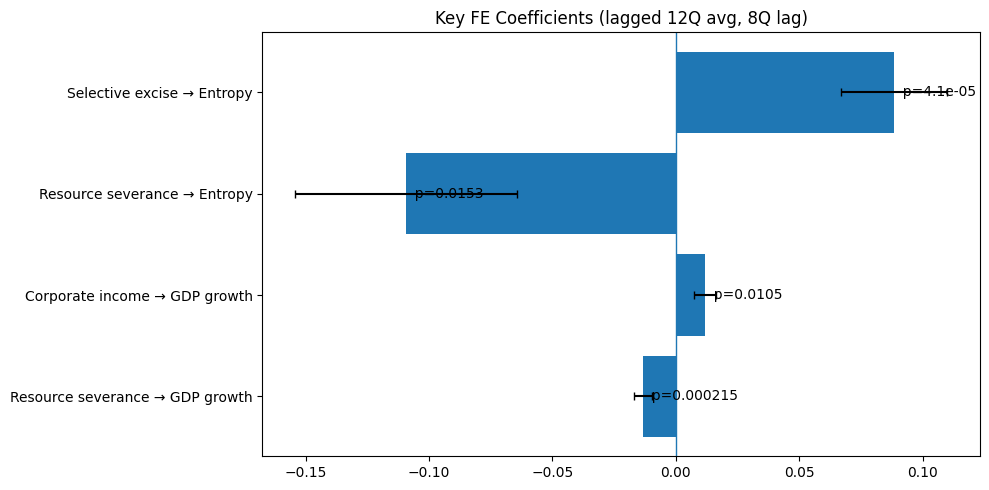

Saved: /Users/jeffallen/Development/portfolio-projects/UmichDatathon2026/outputs/figures/coef_key_results.png


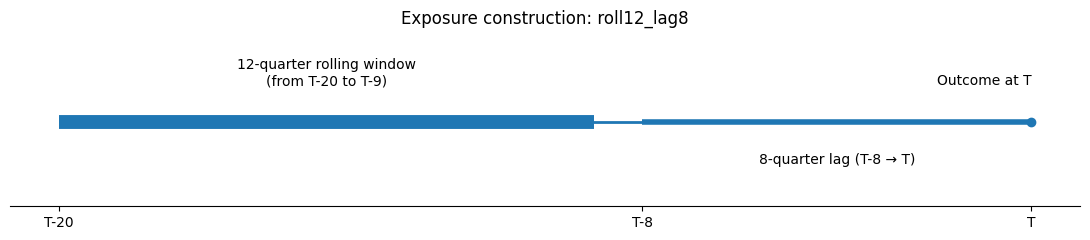

Saved: /Users/jeffallen/Development/portfolio-projects/UmichDatathon2026/outputs/figures/roll12_lag8_timeline.png


In [117]:
# visuals.py (or paste into a notebook cell)
# Creates two visuals:
# 1) Coefficient bar chart comparing outcomes (GDP growth vs econ entropy)
# 2) Simple timeline diagram explaining roll12_lag8 construction
#
# Notes:
# - Uses matplotlib only (no seaborn)
# - Does not set explicit colors (uses matplotlib defaults)
# - Saves PNGs to ./outputs/figures/

FIG_DIR = outputs_folder / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

SUMMARY_PATH = outputs_folder / "tables/panel_model_summary_all.csv"
assert SUMMARY_PATH.exists(), f"Missing: {SUMMARY_PATH}"

summ = pd.read_csv(SUMMARY_PATH)

# ----------------------------
# Helper: get specific coef rows
# ----------------------------
def get_coef_row(outcome: str, term: str) -> pd.DataFrame:
    """Return all rows matching outcome + term (sometimes multiple exposures/specs)."""
    s = summ[(summ["outcome"] == outcome) & (summ["term"] == term)].copy()
    return s

def pick_best_row(df: pd.DataFrame) -> pd.Series:
    """
    If multiple rows exist for same (outcome, term), pick the one with largest |t|.
    """
    if df.empty:
        raise ValueError("No rows found.")
    if "t" in df.columns:
        return df.loc[df["t"].abs().idxmax()]
    # fallback: smallest p-value
    if "p_value" in df.columns:
        return df.loc[df["p_value"].idxmin()]
    return df.iloc[0]

# ----------------------------
# 1) Coefficient bar chart (core results)
# ----------------------------
# Terms/outcomes you said were meaningful:
# GDP growth: resource_severance (neg), corporate_income (pos)
# Entropy: resource_severance (neg), selective_excise (pos)
targets = [
    # (label, outcome, term)
    ("Resource severance → GDP growth", "delta_gdp_per_capita_lag8", "resource_severance_roll12_lag8_dm"),
    ("Corporate income → GDP growth",   "delta_gdp_per_capita_lag8", "corporate_income_roll12_lag8_dm"),
    ("Resource severance → Entropy",    "econ_entropy_norm",         "resource_severance_roll12_lag8_dm"),
    ("Selective excise → Entropy",      "econ_entropy_norm",         "selective_excise_roll12_lag8_dm"),
]

rows = []
for label, outcome, term in targets:
    df = get_coef_row(outcome, term)
    # Optional: restrict to lag8 exposure spec if multiple variants exist
    if "exposure" in df.columns:
        df = df[df["exposure"].str.contains("_roll12_lag8", na=False)]
    r = pick_best_row(df)
    rows.append({
        "label": label,
        "outcome": outcome,
        "term": term,
        "coef": float(r["coef"]),
        "std_err": float(r["std_err"]) if "std_err" in r else None,
        "t": float(r["t"]) if "t" in r else None,
        "p_value": float(r["p_value"]) if "p_value" in r else None,
        "exposure": r.get("exposure", ""),
    })

coef_df = pd.DataFrame(rows)

# Plot as horizontal bars with error bars if std_err available
fig, ax = plt.subplots(figsize=(10, 5))

y = range(len(coef_df))
ax.barh(
    y=y,
    width=coef_df["coef"],
    xerr=coef_df["std_err"] if coef_df["std_err"].notna().all() else None,
    capsize=3
)

ax.axvline(0, linewidth=1)
ax.set_yticks(list(y))
ax.set_yticklabels(coef_df["label"])
ax.set_title("Key FE Coefficients (lagged 12Q avg, 8Q lag)")

# Optional small annotations (p-values)
# (kept minimal; comment out if you want cleaner)
for i, row in coef_df.reset_index(drop=True).iterrows():
    if row["p_value"] is not None:
        ax.text(
            x=row["coef"],
            y=i,
            s=f"  p={row['p_value']:.3g}",
            va="center",
        )

plt.tight_layout()
out_path = FIG_DIR / "coef_key_results.png"
plt.savefig(out_path, dpi=200)
plt.show()

print("Saved:", out_path)

# ----------------------------
# 2) Timeline diagram: what roll12_lag8 means
# ----------------------------
# This produces a simple, judge-friendly diagram: outcome quarter T,
# lag (8 quarters), then rolling window length (12 quarters).
def plot_roll12_lag8_timeline(filename="roll12_lag8_timeline.png"):
    fig, ax = plt.subplots(figsize=(11, 2.5))

    # Arbitrary axis units; just a conceptual timeline
    # We'll mark: [T-20 ... T-9] window, gap to T, and outcome at T
    # Positions:
    # left=0, right=20 represent 20 quarters back to now
    ax.set_ylim(0, 1)
    ax.set_xlim(-1, 21)
    ax.set_yticks([])
    ax.set_xticks([0, 12, 20])
    ax.set_xticklabels(["T-20", "T-8", "T"])
    ax.set_title("Exposure construction: roll12_lag8", pad=10)

    # Baseline timeline
    ax.hlines(0.5, 0, 20, linewidth=2)

    # Rolling window used for exposure: T-20 to T-9 (12 quarters)
    # On this axis, T-20 is x=0, T-8 is x=12, T is x=20.
    # Window ends at T-8 minus 1 quarter => T-9 ~ x=11
    ax.hlines(0.5, 0, 11, linewidth=10)  # thick segment = 12Q window
    ax.text(5.5, 0.72, "12-quarter rolling window\n(from T-20 to T-9)", ha="center")

    # Lag gap (from end of window to outcome): approx 8 quarters (T-8 to T)
    ax.hlines(0.5, 12, 20, linewidth=4)
    ax.text(16, 0.25, "8-quarter lag (T-8 → T)", ha="center")

    # Mark outcome at T
    ax.plot(20, 0.5, marker="o")
    ax.text(20, 0.72, "Outcome at T", ha="right")

    # Clean frame
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    outp = FIG_DIR / filename
    plt.savefig(outp, dpi=200)
    plt.show()
    print("Saved:", outp)

plot_roll12_lag8_timeline()
